In [117]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score

import os
from functools import reduce

from scipy.stats import ks_2samp
from scikitplot.metrics import plot_ks_statistic,plot_roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',500)
pd.set_option('display.float_format',lambda x:'%.8f'%x)

## Cargar datos y categorizar variables

In [2]:
ruta='/home/oszwaldo/Documentos/Projects/Selectos/Unidad 2/Hojas de cálculo'
r=os.listdir('/home/oszwaldo/Documentos/Projects/Selectos/Unidad 2/Hojas de cálculo')[1]
arch= os.path.join(ruta,r)
arch

'/home/oszwaldo/Documentos/Projects/Selectos/Unidad 2/Hojas de cálculo/Cuestionario Diagnóstico 2019 - 1 (Respuestas).xlsx'

In [3]:
df = pd.read_excel(arch)
print(df.shape)
df = df.loc[df['Edad 🎂']<=40].reset_index(drop=True)
df = df.loc[df['¿Cuántos cuartos para dormir tiene tu vivienda?']>0].reset_index(drop=True)
df = df.loc[df['¿A cuánto aproximadamente ascienden los ingresos de tu hogar(considerando a todos los que aportan)?']<=100000].reset_index(drop=True)
df = df.loc[df['¿En cuántos años lo terminaste?']<=5].reset_index(drop=True)
print(df.shape)

(228, 81)
(222, 81)


In [4]:
varc = ['Edad 🎂',
        '¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱',
        '¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti',
        '¿Cuántos son hombres?',
        '¿Cuántas son mujeres?',
        '¿Cuánto tiempo llevas viviendo ahí? (años)',
        '¿Cuántos cuartos para dormir tiene tu vivienda?',
        '¿Cuántos automóviles en total tienen las personas que conforman tu hogar?',
        '¿Cuántas horas trabajas a la semana?',
        '¿Qué promedio obtuviste en el bachillerato?',
        '¿En cuántos años lo terminaste?',
        '¿A cuánto aproximadamente ascienden los ingresos de tu hogar(considerando a todos los que aportan)?',
        '¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Deportes ⚽️🏀🏈]',
        '¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Actividades culturales 🎭🎬🎻]',
        '¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Actividades sociales (fiestas, reuniones con amigos, familia, etc.)]',
        '¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]'
       ]

vard = ['Estado civil','¿Tienes hijos?',
        '¿Tienes alguna dificultad para? [👓 Ver]',
        '¿Tienes alguna dificultad para? [👂 Escuchar]',
        '¿Tienes alguna dificultad para? [💪 Realizar alguna actividad física]',
        '¿Dónde vives actualmente?',
        '¿En qué delegación o municipio?',
        '¿Qué medio de transporte utilizas para llegar a la facultad?',
        '¿Cuál de las siguientes opciones describe tu tipo de vivienda?',
        '¿Con quién vives? (Puedes seleccionar más de una)',
        '¿Cuál es el máximo nivel de estudios de tu papá?',
        '¿Cuál es el máximo nivel de estudios de tu mamá?',
        'En caso de que tengas smartphone ¿Qué sistema operativo tiene?',
        '¿Dónde vivirás mientras cursas tus estudios universitarios?',
        '¿De qué forma financiarás tus estudios universitarios?',
        '¿En dónde cursaste el bachillerato?','¿Cómo se llama la institución donde cursaste el bachillerato?',
        '¿Recibiste alguna beca?','¿Cuál fue el proceso de admisión por el que entraste a esta carrera?',
        'Escoger ésta carrera fue...','Al escoger la FES Acatlán ésta fue:',
        '¿Cuándo tomaste la decisión de lo que querías estudiar?'   
       ]
tgt = 'Carrera'

## Normalizar variables discretas

In [5]:
for v in vard:
    df[v].fillna('MISSING',inplace=True)

In [6]:
def normalizar(df,v,umbral=0.05):
    aux = df[v].value_counts(True).to_frame()
    aux['norm'] = np.where(aux[v]<umbral,'Otros',aux.index)
    grupo = aux.loc[aux['norm']=='Otros'][v].sum()
    if grupo<umbral:
        aux['norm'].replace({'Otros':aux.index[0]},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    return v,aux.to_dict()['norm']

In [7]:
l_norm = list(map(lambda v:normalizar(df,v),vard)    )

In [8]:
normalizar(df,'Estado civil')

('Estado civil',
 {'👤 Soltero': '👤 Soltero',
  '👥 En una relación': '👥 En una relación',
  '💍 Casado': '👤 Soltero'})

In [9]:
f'n_{vard[0]}'

'n_Estado civil'

In [10]:
for v,d in l_norm:
    df[f'n_{v}'] = df[v].replace(d)

In [11]:
varn = df.filter(like='n_').columns.tolist()

In [12]:
for v in varn:
    print(v,'\n')
    print(df[v].value_counts(True).sort_index())
    print('\n'*2)

n_Estado civil 

👤 Soltero           0.7793
👥 En una relación   0.2207
Name: n_Estado civil, dtype: float64



n_¿Tienes hijos? 

No   1.0000
Name: n_¿Tienes hijos?, dtype: float64



n_¿Tienes alguna dificultad para? [👓 Ver] 

No   0.5135
Si   0.4865
Name: n_¿Tienes alguna dificultad para? [👓 Ver], dtype: float64



n_¿Tienes alguna dificultad para? [👂 Escuchar] 

No   1.0000
Name: n_¿Tienes alguna dificultad para? [👂 Escuchar], dtype: float64



n_¿Tienes alguna dificultad para? [💪 Realizar alguna actividad física] 

No   1.0000
Name: n_¿Tienes alguna dificultad para? [💪 Realizar alguna actividad física], dtype: float64



n_¿Dónde vives actualmente? 

CDMX               0.3829
Estado de México   0.6171
Name: n_¿Dónde vives actualmente?, dtype: float64



n_¿En qué delegación o municipio? 

Naucalpan   0.0856
Otros       0.9144
Name: n_¿En qué delegación o municipio?, dtype: float64



n_¿Qué medio de transporte utilizas para llegar a la facultad? 

Transporte público (metro, metrobu

In [13]:
unarias = [v for v in varn if df[v].value_counts().shape[0]==1]

In [14]:
varn = [v for v in varn if v not in unarias]

In [15]:
df[['¿Cuántas horas trabajas a la semana?']]

,¿Cuántas horas trabajas a la semana?
0,0.0000
1,nan
2,nan
3,0.0000
4,0.0000
...,...
217,0.0000
218,0.0000
219,0.0000
220,nan


## Discretización de variables continuas

In [16]:
miss, nomiss = df.loc[df[v].isnull()][[v]],df.loc[~df[v].isnull()][[v]]

In [17]:
miss[[v]].head()

,n_¿Cuándo tomaste la decisión de lo que querías estudiar?


In [18]:
l = []
for v in varc:
    for st in ['uniform','quantile']:
        for k in range(2,6):
            kb = KBinsDiscretizer(n_bins=k,
                                  strategy=st,
                                  encode='ordinal')
            
            miss, nomiss = df.loc[df[v].isnull()][[v]],df.loc[~df[v].isnull()][[v]]    
            kb.fit(nomiss[[v]])
            nombre = f'd_{v}_{k}_{st[:3]}' 
            miss[nombre] = miss[v].fillna('MISSING')
            nomiss[nombre] = pd.cut(nomiss[v],bins=kb.bin_edges_[0],include_lowest=True).astype(str)
            l.append(pd.concat([nomiss[[nombre]],miss[[nombre]]]))
            if df[v].isnull().astype(int).cumsum()[221]>0:
                print(v)
                print(miss[nombre])
                print(nomiss[nombre])

¿Cuántas horas trabajas a la semana?
1      MISSING
2      MISSING
6      MISSING
7      MISSING
9      MISSING
        ...   
208    MISSING
209    MISSING
210    MISSING
216    MISSING
220    MISSING
Name: d_¿Cuántas horas trabajas a la semana?_2_uni, Length: 103, dtype: object
0      (-0.001, 18.5]
3      (-0.001, 18.5]
4      (-0.001, 18.5]
5        (18.5, 37.0]
8      (-0.001, 18.5]
            ...      
215    (-0.001, 18.5]
217    (-0.001, 18.5]
218    (-0.001, 18.5]
219    (-0.001, 18.5]
221    (-0.001, 18.5]
Name: d_¿Cuántas horas trabajas a la semana?_2_uni, Length: 119, dtype: object
¿Cuántas horas trabajas a la semana?
1      MISSING
2      MISSING
6      MISSING
7      MISSING
9      MISSING
        ...   
208    MISSING
209    MISSING
210    MISSING
216    MISSING
220    MISSING
Name: d_¿Cuántas horas trabajas a la semana?_3_uni, Length: 103, dtype: object
0      (-0.001, 12.333]
3      (-0.001, 12.333]
4      (-0.001, 12.333]
5      (12.333, 24.667]
8      (-0.001, 12.33

In [19]:
dfd = reduce(lambda x,y:pd.merge(x,y,left_index=True,right_index=True,how='outer'),l)

In [20]:
dfd.shape,df.shape

((222, 128), (222, 103))

In [21]:
dfd[['d_¿Cuántas horas trabajas a la semana?_2_uni']].head()

,d_¿Cuántas horas trabajas a la semana?_2_uni
0,"(-0.001, 18.5]"
1,MISSING
2,MISSING
3,"(-0.001, 18.5]"
4,"(-0.001, 18.5]"


## Juntar discretas, continuas y target

In [22]:
df[[tgt]+varn]

,Carrera,n_Estado civil,n_¿Tienes alguna dificultad para? [👓 Ver],n_¿Dónde vives actualmente?,n_¿En qué delegación o municipio?,n_¿Qué medio de transporte utilizas para llegar a la facultad?,n_¿Cuál de las siguientes opciones describe tu tipo de vivienda?,n_¿Con quién vives? (Puedes seleccionar más de una),n_¿Cuál es el máximo nivel de estudios de tu papá?,n_¿Cuál es el máximo nivel de estudios de tu mamá?,n_En caso de que tengas smartphone ¿Qué sistema operativo tiene?,n_¿Dónde vivirás mientras cursas tus estudios universitarios?,n_¿De qué forma financiarás tus estudios universitarios?,n_¿En dónde cursaste el bachillerato?,n_¿Cómo se llama la institución donde cursaste el bachillerato?,n_¿Recibiste alguna beca?,n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?,n_Escoger ésta carrera fue...,n_Al escoger la FES Acatlán ésta fue:,n_¿Cuándo tomaste la decisión de lo que querías estudiar?
0,Matemáticas Aplicadas y Computación,👤 Soltero,Si,CDMX,Otros,"Transporte público (metro, metrobus, micro, co...",Rentada,"👩🏽 Mamá, 👨🏽 Papá, 👦🏽👧🏽 Hermano(s)",Primaria,Bachillerato,Android,En el mismo lugar,Ayuda de mis padres u otros familiares,Escuela Nacional Preparatoria (UNAM),Otros,Sí,Pase reglamentado,❤️ Mi primera opción,☔️ No quería este plantel,Durante el bachillerato
1,Matemáticas Aplicadas y Computación,👤 Soltero,Si,Estado de México,Naucalpan,"Transporte público (metro, metrobus, micro, co...",Ocupada sin pagar renta (incluye casa de famil...,Otros,Bachillerato,Licenciatura,Android,En el mismo lugar,Ayuda de mis padres u otros familiares,Escuela Nacional Preparatoria (UNAM),CCH,Sí,Pase reglamentado,😊 Mi segunda opción,☀️ Mi primera opción,Durante el bachillerato
2,Matemáticas Aplicadas y Computación,👤 Soltero,No,Estado de México,Otros,"Transporte público (metro, metrobus, micro, co...",Rentada,"👩🏽 Mamá, 👦🏽👧🏽 Hermano(s)",Secundaria,Bachillerato,Android,En el mismo lugar,Ayuda de mis padres u otros familiares,Escuela Nacional Preparatoria (UNAM),Otros,Sí,Pase reglamentado,❤️ Mi primera opción,☔️ No quería este plantel,Durante el bachillerato
3,Matemáticas Aplicadas y Computación,👥 En una relación,Si,CDMX,Otros,"Vehículo propio (Automóvil, motocicleta, moton...",Propia (ya esta pagada),Otros,Licenciatura,Bachillerato,iOS,En el mismo lugar,Ayuda de mis padres u otros familiares,Escuela Nacional Preparatoria (UNAM),Otros,Sí,Pase reglamentado,❤️ Mi primera opción,☀️ Mi primera opción,Durante el bachillerato
4,Matemáticas Aplicadas y Computación,👤 Soltero,Si,CDMX,Otros,"Transporte público (metro, metrobus, micro, co...",Propia (ya esta pagada),Otros,Bachillerato,Secundaria,Android,En el mismo lugar,Ayuda de mis padres u otros familiares,Escuela pública,Otros,Sí,Concurso de selección,❤️ Mi primera opción,☀️ Mi primera opción,Al terminar el bachillerato
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Actuaria,👤 Soltero,No,Estado de México,Otros,"Transporte público (metro, metrobus, micro, co...",Propia (se esta pagando),"👩🏽 Mamá, 👨🏽 Papá",Otros,Licenciatura,iOS,En el mismo lugar,Ayuda de mis padres u otros familiares,Escuela Nacional Preparatoria (UNAM),Otros,No,Pase reglamentado,❤️ Mi primera opción,☀️ Mi primera opción,Durante el bachillerato
218,Actuaria,👤 Soltero,Si,Estado de México,Otros,"Transporte público (metro, metrobus, micro, co...",Propia (ya esta pagada),"👩🏽 Mamá, 👨🏽 Papá, 👦🏽👧🏽 Hermano(s)",Primaria,Primaria,Android,Otros,Ayuda de mis padres u otros familiares,Escuela Nacional Preparatoria (UNAM),Otros,Sí,Pase reglamentado,❤️ Mi primera opción,☔️ No quería este plantel,Durante el bachillerato
219,Actuaria,👥 En una relación,Si,CDMX,Otros,"Transporte público (metro, metrobus, micro, co...",Propia (se esta pagando),"👩🏽 Mamá, 👨🏽 Papá, 👦🏽👧🏽 Hermano(s)",Bachillerato,Bachillerato,Android,En el mismo lugar,Becas UNAM,Escuela Nacional Preparatoria (UNAM),Otros,Sí,Pase reglamentado,❤️ Mi primera opción,☔️ No quería este plantel,Durante el bachillerato
220,Actuaria,👤 Soltero,No,CDMX,

In [23]:
df = df[[tgt]+varn].merge(dfd,left_index=True,right_index=True,how='outer')

In [24]:
df[tgt] = (df[tgt] =='Actuaria').astype(int)

In [25]:
df[tgt].value_counts(1)

1   0.6802
0   0.3198
Name: Carrera, dtype: float64

In [26]:
df.head()

,Carrera,n_Estado civil,n_¿Tienes alguna dificultad para? [👓 Ver],n_¿Dónde vives actualmente?,n_¿En qué delegación o municipio?,n_¿Qué medio de transporte utilizas para llegar a la facultad?,n_¿Cuál de las siguientes opciones describe tu tipo de vivienda?,n_¿Con quién vives? (Puedes seleccionar más de una),n_¿Cuál es el máximo nivel de estudios de tu papá?,n_¿Cuál es el máximo nivel de estudios de tu mamá?,n_En caso de que tengas smartphone ¿Qué sistema operativo tiene?,n_¿Dónde vivirás mientras cursas tus estudios universitarios?,n_¿De qué forma financiarás tus estudios universitarios?,n_¿En dónde cursaste el bachillerato?,n_¿Cómo se llama la institución donde cursaste el bachillerato?,n_¿Recibiste alguna beca?,n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?,n_Escoger ésta carrera fue...,n_Al escoger la FES Acatlán ésta fue:,n_¿Cuándo tomaste la decisión de lo que querías estudiar?,d_Edad 🎂_2_uni,d_Edad 🎂_3_uni,d_Edad 🎂_4_uni,d_Edad 🎂_5_uni,d_Edad 🎂_2_qua,d_Edad 🎂_3_qua,d_Edad 🎂_4_qua,d_Edad 🎂_5_qua,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_2_uni,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_3_uni,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_4_uni,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_5_uni,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_2_qua,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_3_qua,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_4_qua,d_¿Cuánto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ⏱_5_qua,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_2_uni,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_3_uni,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_4_uni,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_uni,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_2_qua,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_3_qua,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_4_qua,d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_qua,d_¿Cuántos son hombres?_2_uni,d_¿Cuántos son hombres?_3_uni,d_¿Cuántos son hombres?_4_uni,d_¿Cuántos son hombres?_5_uni,d_¿Cuántos son hombres?_2_qua,d_¿Cuántos son hombres?_3_qua,d_¿Cuántos son hombres?_4_qua,d_¿Cuántos son hombres?_5_qua,d_¿Cuántas son mujeres?_2_uni,d_¿Cuántas son mujeres?_3_uni,d_¿Cuántas son mujeres?_4_uni,d_¿Cuántas son mujeres?_5_uni,d_¿Cuántas son mujeres?_2_qua,d_¿Cuántas son mujeres?_3_qua,d_¿Cuántas son mujeres?_4_qua,d_¿Cuántas son mujeres?_5_qua,d_¿Cuánto tiempo llevas viviendo ahí? (años)_2_uni,d_¿Cuánto tiempo llevas viviendo ahí? (años)_3_uni,d_¿Cuánto tiempo llevas viviendo ahí? (años)_4_uni,d_¿Cuánto tiempo llevas viviendo ahí? (años)_5_uni,d_¿Cuánto tiempo llevas viviendo ahí? (años)_2_qua,d_¿Cuánto tiempo llevas viviendo ahí? (años)_3_qua,d_¿Cuánto tiempo llevas viviendo ahí? (años)_4_qua,d_¿Cuánto tiempo llevas viviendo ahí? (años)_5_qua,d_¿Cuántos cuartos para dormir tiene tu vivienda?_2_uni,d_¿Cuántos cuartos para dormir tiene tu vivienda?_3_uni,d_¿Cuántos cuartos para dormir tiene tu vivienda?_4_uni,d_¿Cuántos cuartos para dormir tiene tu vivienda?_5_uni,d_¿Cuántos cuartos para dormir tiene tu vivienda?_2_qua,d_¿Cuántos cuartos para dormir tiene tu vivienda?_3_qua,d_¿Cuántos cuartos para dormir tiene tu vivienda?_4_qua,d_¿Cuántos cuartos para dormir tiene tu vivienda?_5_qua,d_¿Cuántos automóviles en total tienen las personas que conforman tu hogar?_2_uni,d_¿Cuántos automóviles en total tienen las personas que conforman tu hogar?_3_uni,d_¿Cuántos automóviles en total tienen las personas que conforman tu hogar?_4_uni,d_¿Cuántos automóviles en total tienen las personas que conforman tu hogar?_5_uni,d_¿Cuántos automóviles en total tienen las personas que conforman tu hoga

## Calcular IV

In [27]:
v = 'n_¿Cuál de las siguientes opciones describe tu tipo de vivienda?'

In [28]:
def iv(df,v,tgt):
    aux = df[[v,tgt]].assign(n=1)
    aux = aux.pivot_table(index=v,
                    columns=tgt,
                    values='n',
                    fill_value=0,
                    aggfunc='sum')
    for i in range(2):
        aux[i]/=aux[i].sum()
    aux['woe'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['woe']
    return v,aux['iv'].sum()

In [29]:
iv(df,v,tgt) # Esta variable no tiene mucha información

('n_¿Cuál de las siguientes opciones describe tu tipo de vivienda?',
 0.004659679679024691)

In [30]:
print("""<0.1 Débil
0.1-0.3 Media
0.3-0.5 Fuerte
>0.5 Muy fuerte
""")

<0.1 Débil
0.1-0.3 Media
0.3-0.5 Fuerte
>0.5 Muy fuerte



In [31]:
var = [v for v in df.columns if v != tgt]
var

['n_Estado civil',
 'n_¿Tienes alguna dificultad para? [👓 Ver]',
 'n_¿Dónde vives actualmente?',
 'n_¿En qué delegación o municipio?',
 'n_¿Qué medio de transporte utilizas para llegar a la facultad?',
 'n_¿Cuál de las siguientes opciones describe tu tipo de vivienda?',
 'n_¿Con quién vives? (Puedes seleccionar más de una)',
 'n_¿Cuál es el máximo nivel de estudios de tu papá?',
 'n_¿Cuál es el máximo nivel de estudios de tu mamá?',
 'n_En caso de que tengas smartphone ¿Qué sistema operativo tiene?',
 'n_¿Dónde vivirás mientras cursas tus estudios universitarios?',
 'n_¿De qué forma financiarás tus estudios universitarios?',
 'n_¿En dónde cursaste el bachillerato?',
 'n_¿Cómo se llama la institución donde cursaste el bachillerato?',
 'n_¿Recibiste alguna beca?',
 'n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?',
 'n_Escoger ésta carrera fue...',
 'n_Al escoger la FES Acatlán ésta fue:',
 'n_¿Cuándo tomaste la decisión de lo que querías estudiar?',
 'd_Edad 🎂_2_u

In [32]:
ivdf = pd.DataFrame(map(lambda v:iv(df,v,tgt),var),columns=['variable','iv'])
ivdf = ivdf.sort_values(by='iv',ascending=False).reset_index(drop=True)
ivdf['iv'].replace({np.inf:np.nan,-np.inf:np.nan},inplace=True)# podemos tratar más fácil a nan
ivdf = ivdf.dropna().reset_index(drop=True)
ivdf['raiz'] = ivdf['variable'].map(lambda x:x.split('_')[1] if x[:2]=='d_' else x)
ivdf = ivdf.sort_values(by=['raiz','iv'],ascending=[1,0]).reset_index(drop=True)
ivdf['best'] = ivdf.groupby('raiz').cumcount()+1
ivdf = ivdf.loc[ivdf['best']==1].drop('best',axis=1).sort_values(by='iv',ascending=False).reset_index(drop=True)
ivdf.head()

,variable,iv,raiz
0,d_¿Qué promedio obtuviste en el bachillerato?_...,2.0270,¿Qué promedio obtuviste en el bachillerato?
1,n_Escoger ésta carrera fue...,1.1980,n_Escoger ésta carrera fue...
2,n_¿Cuál fue el proceso de admisión por el que ...,0.4220,n_¿Cuál fue el proceso de admisión por el que ...
3,n_¿Cuándo tomaste la decisión de lo que quería...,0.3481,n_¿Cuándo tomaste la decisión de lo que quería...
4,d_¿En cuántos años lo terminaste?_3_uni,0.3199,¿En cuántos años lo terminaste?


In [33]:
best = ivdf.loc[ivdf['iv']>=0.1]['variable'].tolist()

In [34]:
best

['d_¿Qué promedio obtuviste en el bachillerato?_4_qua',
 'n_Escoger ésta carrera fue...',
 'n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?',
 'n_¿Cuándo tomaste la decisión de lo que querías estudiar?',
 'd_¿En cuántos años lo terminaste?_3_uni',
 'n_¿En dónde cursaste el bachillerato?',
 'd_¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua',
 'n_¿Recibiste alguna beca?',
 'n_Al escoger la FES Acatlán ésta fue:',
 'n_¿Cómo se llama la institución donde cursaste el bachillerato?',
 'd_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_qua',
 'd_¿Cuánto tiempo llevas viviendo ahí? (años)_5_qua',
 'n_¿Cuál es el máximo nivel de estudios de tu mamá?',
 'n_¿Cuál es el máximo nivel de estudios de tu papá?']

## Transformación WoE

In [35]:
X = df[best].copy()
y = df[[tgt]].copy()

In [36]:
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [37]:
Xt[tgt] = yt

In [38]:
def woe(df,v,tgt):
    aux = df[[v,tgt]].assign(n=1)
    aux = aux.pivot_table(index=v,
                    columns=tgt,
                    values='n',
                    fill_value=0,
                    aggfunc='sum')
    for i in range(2):
        aux[i]/=aux[i].sum()
    aux['woe'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1,inplace=True)
    return v,aux.to_dict()['woe']
    

In [39]:
woe(df,v,tgt)

('n_¿Cuál de las siguientes opciones describe tu tipo de vivienda?',
 {'Ocupada sin pagar renta (incluye casa de familiares)': 0.09782042338453845,
  'Propia (se esta pagando)': 0.061452779213663516,
  'Propia (ya esta pagada)': -0.06638059229622123,
  'Rentada': 0.012662615044231714})

In [40]:
mapa_woe = list(map(lambda v:woe(Xt,v,tgt),best))

In [41]:
for v,d in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(d)
    Xv[f'w_{v}'] = Xv[v].replace(d)

In [42]:
varw = [v for v in Xt.columns if v[:2]=='w_']
varw

['w_d_¿Qué promedio obtuviste en el bachillerato?_4_qua',
 'w_n_Escoger ésta carrera fue...',
 'w_n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?',
 'w_n_¿Cuándo tomaste la decisión de lo que querías estudiar?',
 'w_d_¿En cuántos años lo terminaste?_3_uni',
 'w_n_¿En dónde cursaste el bachillerato?',
 'w_d_¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua',
 'w_n_¿Recibiste alguna beca?',
 'w_n_Al escoger la FES Acatlán ésta fue:',
 'w_n_¿Cómo se llama la institución donde cursaste el bachillerato?',
 'w_d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_qua',
 'w_d_¿Cuánto tiempo llevas viviendo ahí? (años)_5_qua',
 'w_n_¿Cuál es el máximo nivel de estudios de tu mamá?',
 'w_n_¿Cuál es el máximo nivel de estudios de tu papá?']

In [43]:
Xt = Xt[varw]
Xv = Xv[varw]

In [51]:
aux = pd.concat([Xt,Xv])
aux = aux.describe().T[['min']]
aux['min'] = np.abs(aux['min'])
aux

,min
w_d_¿Qué promedio obtuviste en el bachillerato?_4_qua,1.3974
w_n_Escoger ésta carrera fue...,0.4166
w_n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?,0.3811
w_n_¿Cuándo tomaste la decisión de lo que querías estudiar?,1.4256
w_d_¿En cuántos años lo terminaste?_3_uni,inf
w_n_¿En dónde cursaste el bachillerato?,0.3858
"w_d_¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua",0.6947
w_n_¿Recibiste alguna beca?,0.3523
w_n_Al escoger la FES Acatlán ésta fue:,0.6147
w_n_¿Cómo se llama la institución donde cursaste el bachillerato?,1.5310


In [52]:
quitar = aux.loc[np.isinf(aux['min'])].index.tolist()
quitar

['w_d_¿En cuántos años lo terminaste?_3_uni']

In [53]:
varw = [v for v in varw if v not in quitar]

In [54]:
Xt = Xt[varw]
Xv = Xv[varw]

## Entrenamiento del modelo

In [55]:
modelo = LogisticRegression()

In [56]:
Xt.describe()

,w_d_¿Qué promedio obtuviste en el bachillerato?_4_qua,w_n_Escoger ésta carrera fue...,w_n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?,w_n_¿Cuándo tomaste la decisión de lo que querías estudiar?,w_n_¿En dónde cursaste el bachillerato?,"w_d_¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua",w_n_¿Recibiste alguna beca?,w_n_Al escoger la FES Acatlán ésta fue:,w_n_¿Cómo se llama la institución donde cursaste el bachillerato?,w_d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_qua,w_d_¿Cuánto tiempo llevas viviendo ahí? (años)_5_qua,w_n_¿Cuál es el máximo nivel de estudios de tu mamá?,w_n_¿Cuál es el máximo nivel de estudios de tu papá?
count,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000,155.0000
mean,-0.2020,0.0504,-0.0522,-0.0627,-0.0417,-0.0659,-0.0358,-0.0326,-0.0390,-0.0386,-0.0226,-0.0239,-0.0526
std,1.4538,1.2926,0.6735,0.5693,0.5148,0.6141,0.4671,0.4115,0.4448,0.4666,0.3593,0.3694,0.5256
min,-1.3974,-0.4166,-0.3811,-1.4256,-0.3858,-0.6947,-0.3523,-0.6147,-1.5310,-0.5682,-0.4223,-0.5406,-1.5310
25%,-1.1653,-0.4166,-0.3811,-0.0613,-0.3858,-0.6591,-0.3523,-0.4324,0.0340,-0.5682,-0.4223,-0.2092,-0.2092
50%,-0.9331,-0.4166,-0.3811,0.1410,-0.3858,0.0785,-0.3523,0.2947,0.0340,0.1250,-0.2317,-0.0451,-0.1898
75%,2.1887,-0.4166,-0.3811,0.1410,0.6538,0.5893,0.6490,0.2947,0.0340,0.1655,0.2120,-0.0393,0.5093
max,2.1887,3.6048,1.3182,1.0593,0.9258,0.8770,0.6490,0.2947,0.7716,0.6975,0.6381,0.5485,0.5093


In [57]:
modelo.fit(Xt,yt)

LogisticRegression()

In [58]:
print(roc_auc_score(y_score=modelo.predict_proba(Xt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modelo.predict_proba(Xv)[:,1],y_true=yv))

0.9466692337312284
0.8666666666666667


## Transformación Scoring

In [59]:
betas = modelo.coef_[0].tolist()
alpha = modelo.intercept_[0]

In [60]:
alpha

0.7591300746506

score_base(score al cual vamos a alinear los momios base), odds_base (momios_base),pdo (points to double the odd's)

In [61]:
score_base = 137 # Empieza aquí
odd_base = 2 #
pdo = 20 # Es decir que en 157 odds=4 y en scorebase=117 odds=1

$factor = pdo/\log(2)\newline
offset = score\_base-factor\log(odds\_base)
\newline
pts = \left(-WoE\cdot\beta+\alpha/n\right)\cdot factor+offset/n
$

In [62]:
factor = pdo/np.log(2)
offset = score_base-factor*np.log(odd_base)

In [63]:
Xt[tgt] = yt
Xv[tgt] = yv

In [121]:
X = pd.concat([Xt,Xv],ignore_index=True)

In [122]:
n = len(varw)

In [123]:
for b,v in zip(betas,varw):
    X[f'pts_{v}'] = np.ceil((-X[v]*b+alpha/n)*factor+offset/n).astype(int)

In [124]:
X['score'] = X.filter(like='pts_').sum(axis=1)
X.head()

,w_d_¿Qué promedio obtuviste en el bachillerato?_4_qua,w_n_Escoger ésta carrera fue...,w_n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?,w_n_¿Cuándo tomaste la decisión de lo que querías estudiar?,w_n_¿En dónde cursaste el bachillerato?,"w_d_¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua",w_n_¿Recibiste alguna beca?,w_n_Al escoger la FES Acatlán ésta fue:,w_n_¿Cómo se llama la institución donde cursaste el bachillerato?,w_d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_qua,w_d_¿Cuánto tiempo llevas viviendo ahí? (años)_5_qua,w_n_¿Cuál es el máximo nivel de estudios de tu mamá?,w_n_¿Cuál es el máximo nivel de estudios de tu papá?,Carrera,pts_w_d_¿Qué promedio obtuviste en el bachillerato?_4_qua,pts_w_n_Escoger ésta carrera fue...,pts_w_n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?,pts_w_n_¿Cuándo tomaste la decisión de lo que querías estudiar?,pts_w_n_¿En dónde cursaste el bachillerato?,"pts_w_d_¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua",pts_w_n_¿Recibiste alguna beca?,pts_w_n_Al escoger la FES Acatlán ésta fue:,pts_w_n_¿Cómo se llama la institución donde cursaste el bachillerato?,pts_w_d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_qua,pts_w_d_¿Cuánto tiempo llevas viviendo ahí? (años)_5_qua,pts_w_n_¿Cuál es el máximo nivel de estudios de tu mamá?,pts_w_n_¿Cuál es el máximo nivel de estudios de tu papá?,score
0,2.18868482,-0.41660565,-0.38106071,-1.42560578,-0.38583399,0.87697931,-0.35231130,-0.43235401,0.03401985,-0.56815555,0.63808740,0.54847524,-0.18979237,0,60,0,5,1,8,24,3,0,12,4,12,28,6,163
1,-1.39743490,-0.41660565,-0.38106071,0.14099197,0.65383576,-0.65912733,-0.35231130,0.29469472,0.03401985,-0.56815555,0.21200301,-0.54056759,-0.18979237,1,-20,0,5,12,16,1,3,19,12,4,12,-6,6,64
2,-1.39743490,-0.41660565,-0.38106071,-0.06129033,0.65383576,0.58929724,-0.35231130,-0.61467557,0.03401985,-0.48114417,0.63808740,0.54847524,0.50925453,1,-20,0,5,11,16,20,3,-4,12,5,12,28,26,114
3,-0.93312930,-0.41660565,-0.38106071,0.14099197,-0.32699349,0.58929724,0.64901647,0.29469472,-1.53096630,0.12499163,-0.42230367,-0.04514234,-1.53096630,1,-10,0,5,12,9,20,26,19,-46,13,10,10,-32,36
4,-0.83781912,-0.41660565,-0.38106071,-1.42560578,-0.38583399,-0.69471827,-0.35231130,0.29469472,0.03401985,-0.56815555,0.21200301,-0.04514234,-0.20921046,1,-8,0,5,1,8,1,3,19,12,4,12,10,5,72


<AxesSubplot:>

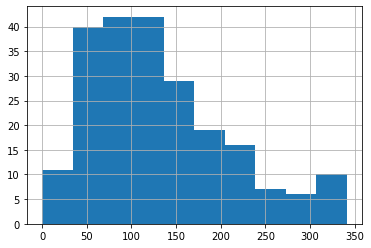

In [109]:
X.score.hist()

In [130]:
X['r_score'] = pd.cut(X['score'],bins=range(0,360+36,36)).astype(str)

In [138]:
isana=X.loc[:,'score'].isna()
igual=X.loc[:,'r_score']== 'nan'
#X.loc[X.loc[:,'score']>=50]
X.loc[151,'r_score'] = '(0.0, 36.0]'

In [71]:
#X.pivot_table(index='r_score',columns=tgt,values='score',aggfunc='count',fill_value=0).to_clipboard()

In [139]:
X.pivot_table(index='r_score',columns=tgt,values='score',aggfunc='count',fill_value=0).sort_index()

Carrera,0,1
r_score,,
"(0.0, 36.0]",0,12
"(108.0, 144.0]",6,35
"(144.0, 180.0]",19,12
"(180.0, 216.0]",12,5
"(216.0, 252.0]",11,0
"(252.0, 288.0]",5,1
"(288.0, 324.0]",9,0
"(324.0, 360.0]",4,0
"(36.0, 72.0]",1,43


In [140]:
varw

['w_d_¿Qué promedio obtuviste en el bachillerato?_4_qua',
 'w_n_Escoger ésta carrera fue...',
 'w_n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?',
 'w_n_¿Cuándo tomaste la decisión de lo que querías estudiar?',
 'w_n_¿En dónde cursaste el bachillerato?',
 'w_d_¿Cuántos días a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua',
 'w_n_¿Recibiste alguna beca?',
 'w_n_Al escoger la FES Acatlán ésta fue:',
 'w_n_¿Cómo se llama la institución donde cursaste el bachillerato?',
 'w_d_¿Cuántas personas en total viven en tu hogar? Incluyéndote a ti_5_qua',
 'w_d_¿Cuánto tiempo llevas viviendo ahí? (años)_5_qua',
 'w_n_¿Cuál es el máximo nivel de estudios de tu mamá?',
 'w_n_¿Cuál es el máximo nivel de estudios de tu papá?']

In [144]:
mapa_woe

[('d_¿Qué promedio obtuviste en el bachillerato?_4_qua',
  {'(6.999, 8.5]': 2.188684815788085,
   '(8.5, 8.815]': -1.3974349043680825,
   '(8.815, 9.1]': -0.9331292962369846,
   '(9.1, 10.0]': -0.8378191164326598}),
 ('n_Escoger ésta carrera fue...',
  {'❤️ Mi primera opción': -0.4166056513563563,
   '😊 Mi segunda opción': 3.6048321400576566}),
 ('n_¿Cuál fue el proceso de admisión por el que entraste a esta carrera?',
  {'Concurso de selección': 1.3181625023695103,
   'Pase reglamentado': -0.381060713936945}),
 ('n_¿Cuándo tomaste la decisión de lo que querías estudiar?',
  {'Al terminar el bachillerato': -0.061290326933663444,
   'Antes del bachillerato': -1.4256057813347789,
   'Durante el bachillerato': 0.1409919724228292,
   'En otro momento o circunstancia': 1.0593008684532212}),
 ('d_¿En cuántos años lo terminaste?_3_uni',
  {'(0.999, 2.333]': -inf,
   '(2.333, 3.667]': -0.10191007653463291,
   '(3.667, 5.0]': 1.8702310846695502}),
 ('n_¿En dónde cursaste el bachillerato?',
  {'

In [141]:
l = []
for v,d in mapa_woe:
    if 'w_%s'%v in varw:
        d = {y:x for x,y in d.items()}
        aux = X[['w_%s'%v,'pts_w_%s'%v]].copy()
        aux.drop_duplicates(inplace=True)
        aux['w_%s'%v].replace(d,inplace=True)
        aux.rename(columns={'w_%s'%v:'atributo','pts_w_%s'%v:'puntos'},inplace=True)
        aux['característica'] = v
        l.append(aux)

In [142]:
l

[       atributo  puntos                                     característica
 0  (6.999, 8.5]      60  d_¿Qué promedio obtuviste en el bachillerato?_...
 1  (8.5, 8.815]     -20  d_¿Qué promedio obtuviste en el bachillerato?_...
 3  (8.815, 9.1]     -10  d_¿Qué promedio obtuviste en el bachillerato?_...
 4   (9.1, 10.0]      -8  d_¿Qué promedio obtuviste en el bachillerato?_...,
                atributo  puntos                 característica
 0  ❤️ Mi primera opción       0  n_Escoger ésta carrera fue...
 5   😊 Mi segunda opción     106  n_Escoger ésta carrera fue...,
                 atributo  puntos  \
 0      Pase reglamentado       5   
 5  Concurso de selección      34   
 
                                       característica  
 0  n_¿Cuál fue el proceso de admisión por el que ...  
 5  n_¿Cuál fue el proceso de admisión por el que ...  ,
                            atributo  puntos  \
 0            Antes del bachillerato       1   
 1           Durante el bachillerato      12   


In [76]:
scorecard = pd.concat(l,ignore_index=True)
scorecard

,atributo,puntos,característica
0,"(6.999, 8.5]",60,d_¿Qué promedio obtuviste en el bachillerato?_...
1,"(8.5, 8.815]",-20,d_¿Qué promedio obtuviste en el bachillerato?_...
2,"(8.815, 9.1]",-10,d_¿Qué promedio obtuviste en el bachillerato?_...
3,"(9.1, 10.0]",-8,d_¿Qué promedio obtuviste en el bachillerato?_...
4,❤️ Mi primera opción,0,n_Escoger ésta carrera fue...
5,😊 Mi segunda opción,106,n_Escoger ésta carrera fue...
6,Pase reglamentado,5,n_¿Cuál fue el proceso de admisión por el que ...
7,Concurso de selección,34,n_¿Cuál fue el proceso de admisión por el que ...
8,Antes del bachillerato,1,n_¿Cuándo tomaste la decisión de lo que quería...
9,Durante el bachillerato,12,n_¿Cuándo tomaste la decisión de lo que quería...


In [77]:
with pd.ExcelWriter('scorecard.xlsx') as xl:
    scorecard.groupby(['característica','atributo']).max().to_excel(xl,sheet_name='scorecard')
    xl.close()